## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('train.csv', delimiter=',')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [3]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
338632,338632,466194,466195,Are cats really affected by the full moon?,Are cats affected by a full moon?,1
110156,110156,180665,180666,What is your best recipe?,What is the best recipe in the world?,0
230844,230844,340500,340501,What would happen in US politics if everyone t...,What would the government be like if only the ...,0
327541,327541,453974,453975,Where can I get the latest dataset for a netwo...,IDS: What are other data (except KDD and DARPA...,0
63969,63969,111230,111231,Would/should you ever let your pregnant wife c...,What is your favorite dog and why?,0


### Exploration

In [4]:
df.shape


(404290, 6)

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


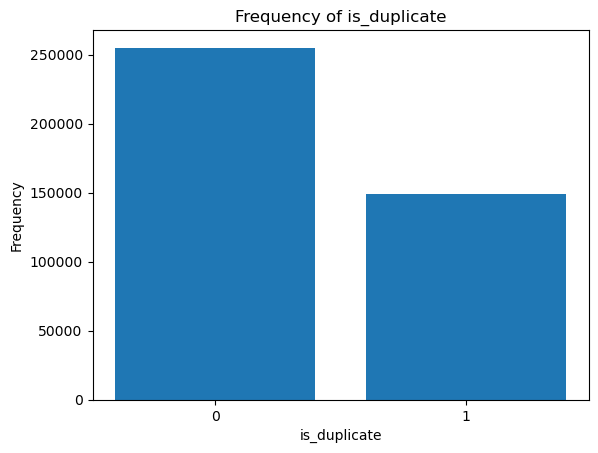

In [8]:
value_counts_labels= df['is_duplicate'].value_counts()

# Plot the frequency
plt.bar(value_counts_labels.index, value_counts_labels.values)
plt.xlabel('is_duplicate')
plt.ylabel('Frequency')
plt.title('Frequency of is_duplicate')
# Set the x-axis tick labels as integers
plt.xticks(value_counts_labels.index.astype(int))

plt.show()

The data is imbalanced

In [9]:
df['qid1'].nunique()

290654

We have 290654 unique questions out of 404290 in q1

In [10]:
df['qid2'].nunique()

299364

We have 299364 unique questions out of 404290 in q2

In [11]:
# looking for total unique questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

qid.nunique()


537933

In [12]:
# Drop rows with missing values in-place
df.dropna(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [14]:
# Removing punctuation
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# Define a function to remove punctuation in our messages
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [16]:
df['q1_clean'] = df['question1'].apply(lambda x: remove_punct(x))
df['q2_clean'] = df['question2'].apply(lambda x: remove_punct(x))

In [17]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean
355654,355654,484898,484899,I am currently an English major and I want to ...,I am a BTech pursuing student and I want to do...,0,I am currently an English major and I want to ...,I am a BTech pursuing student and I want to do...
224007,224007,331968,331969,Why would someone choose UCLA's Film School ov...,What would happen if UCLA and USC were one sch...,0,Why would someone choose UCLAs Film School ove...,What would happen if UCLA and USC were one school
42802,42802,77073,77074,"What does the phrase, ""turn down for what"" fro...",What does it mean that smallest coffins are th...,0,What does the phrase turn down for what from t...,What does it mean that smallest coffins are th...
247013,247013,360162,360163,What is the difference between manure and fert...,What is the best way to use a 500SQM parcel of...,0,What is the difference between manure and fert...,What is the best way to use a 500SQM parcel of...
253240,253240,114094,354475,How can I send a private message through Quora?,Quora: How do you message someone through thei...,1,How can I send a private message through Quora,Quora How do you message someone through their...
245728,245728,23269,346968,What can be done to end caste based reservatio...,What will it take to remove caste based reserv...,1,What can be done to end caste based reservatio...,What will it take to remove caste based reserv...
66086,66086,114601,114602,What's the best way to explain to a young chil...,What's the best way to tell a young child that...,0,Whats the best way to explain to a young child...,Whats the best way to tell a young child that ...
374541,374541,313840,49764,How can we make money out of blogs?,How do you make money writing a blog?,1,How can we make money out of blogs,How do you make money writing a blog
63366,63366,110284,31839,Will eating too many carrots turn your skin or...,How many carrots can you eat before you turn o...,1,Will eating too many carrots turn your skin or...,How many carrots can you eat before you turn o...
171874,171874,66240,265512,Does meditation help against anxiety?,Will meditating regularly really help me with ...,1,Does meditation help against anxiety,Will meditating regularly really help me with ...


In [18]:
import re

def tokenize(text):
    tokens = text.split()
    return tokens

In [19]:
df['q1_tokenized'] = df['q1_clean'].apply(lambda x: tokenize(x.lower()))
df['q2_tokenized'] = df['q2_clean'].apply(lambda x: tokenize(x.lower()))


In [20]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized
104215,104215,21553,110747,What are some of the top paying career options...,How will be my career if I chose MBA after b.t...,1,What are some of the top paying career options...,How will be my career if I chose MBA after bte...,"[what, are, some, of, the, top, paying, career...","[how, will, be, my, career, if, i, chose, mba,..."
394392,394392,204931,527278,What was Steve Jobs' typical day like?,How many hours did Steve Jobs work per day?,0,What was Steve Jobs typical day like,How many hours did Steve Jobs work per day,"[what, was, steve, jobs, typical, day, like]","[how, many, hours, did, steve, jobs, work, per..."
179108,179108,20100,274921,How can one earn money with a Facebook page?,How can you earn money with a Facebook group?,0,How can one earn money with a Facebook page,How can you earn money with a Facebook group,"[how, can, one, earn, money, with, a, facebook...","[how, can, you, earn, money, with, a, facebook..."
161019,161019,58038,29328,How can we write a essay?,How can I write an essay efficiently?,1,How can we write a essay,How can I write an essay efficiently,"[how, can, we, write, a, essay]","[how, can, i, write, an, essay, efficiently]"
29485,29485,54547,54548,What are some schools that use project-based l...,What are some schools that use project based l...,0,What are some schools that use projectbased le...,What are some schools that use project based l...,"[what, are, some, schools, that, use, projectb...","[what, are, some, schools, that, use, project,..."
45307,45307,81212,81213,How can I find what I love to do?,How do you do what you love?,0,How can I find what I love to do,How do you do what you love,"[how, can, i, find, what, i, love, to, do]","[how, do, you, do, what, you, love]"
23917,23917,44755,37295,What's your opinion of masturbation?,What is your opinion on masturbation?,1,Whats your opinion of masturbation,What is your opinion on masturbation,"[whats, your, opinion, of, masturbation]","[what, is, your, opinion, on, masturbation]"
230560,230560,168837,340122,What is craigslist?,What is Craigslist's revenue?,0,What is craigslist,What is Craigslists revenue,"[what, is, craigslist]","[what, is, craigslists, revenue]"
108979,108979,178938,88943,How would you explain a computer to your great...,How can I use the Assimil Japanese with ease?,0,How would you explain a computer to your great...,How can I use the Assimil Japanese with ease,"[how, would, you, explain, a, computer, to, yo...","[how, can, i, use, the, assimil, japanese, wit..."
43838,43838,78800,78801,Do dating apps really find a date for you?,Does dating site really work?,1,Do dating apps really find a date for you,Does dating site really work,"[do, dating, apps, really, find, a, date, for,...","[does, dating, site, really, work]"


In [21]:
!pip install -U nltk

In [22]:
# Import the NLTK package and download the necessary data
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Define a function to remove all stopwords
def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in stopwords.words('english')]
    return text

In [24]:
df['q1_nostop'] = df['q1_tokenized'].apply(lambda x: remove_stopwords(x))
df['q2_nostop'] = df['q2_tokenized'].apply(lambda x: remove_stopwords(x))

In [25]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop
383084,383084,380535,515000,Can I download my Youtube videos to my SD card?,How do I watch/download an age-restricted vide...,0,Can I download my Youtube videos to my SD card,How do I watchdownload an agerestricted video ...,"[can, i, download, my, youtube, videos, to, my...","[how, do, i, watchdownload, an, agerestricted,...","[download, youtube, videos, sd, card]","[watchdownload, agerestricted, video, youtube,..."
178924,178924,274678,274679,Are fitness bands good?,Are fitness bands helpful?,1,Are fitness bands good,Are fitness bands helpful,"[are, fitness, bands, good]","[are, fitness, bands, helpful]","[fitness, bands, good]","[fitness, bands, helpful]"
35746,35746,65279,65280,How do you convert these fractions into decimals?,What is the equation to convert a decimal into...,0,How do you convert these fractions into decimals,What is the equation to convert a decimal into...,"[how, do, you, convert, these, fractions, into...","[what, is, the, equation, to, convert, a, deci...","[convert, fractions, decimals]","[equation, convert, decimal, fraction583]"
134145,134145,99894,214463,What is the best diet for muscle building?,What is the best diet for building muscle?,1,What is the best diet for muscle building,What is the best diet for building muscle,"[what, is, the, best, diet, for, muscle, build...","[what, is, the, best, diet, for, building, mus...","[best, diet, muscle, building]","[best, diet, building, muscle]"
361327,361327,255442,491156,What are the different grade levels and titles...,What are the different career bands in HSBC GL...,0,What are the different grade levels and titles...,What are the different career bands in HSBC GL...,"[what, are, the, different, grade, levels, and...","[what, are, the, different, career, bands, in,...","[different, grade, levels, titles, hsbc]","[different, career, bands, hsbc, glt, india, r..."


In [26]:
# importing modules 
nltk.download('punkt')
from nltk.stem import PorterStemmer



[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# # Stem the tokens
stemmer = PorterStemmer()
df['q1_stemmed'] = df['q1_nostop'].apply(lambda x: [stemmer.stem(word) for word in x])
df['q2_stemmed'] = df['q2_nostop'].apply(lambda x: [stemmer.stem(word) for word in x])

In [28]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed
300656,300656,94809,210055,How do you look up license plate numbers?,What do you do if you forgot your license plat...,0,How do you look up license plate numbers,What do you do if you forgot your license plat...,"[how, do, you, look, up, license, plate, numbers]","[what, do, you, do, if, you, forgot, your, lic...","[look, license, plate, numbers]","[forgot, license, plate, number]","[look, licens, plate, number]","[forgot, licens, plate, number]"
314978,314978,439812,6261,What is the funniest email address you've ever...,I forgot my password and the email address I u...,0,What is the funniest email address youve ever ...,I forgot my password and the email address I u...,"[what, is, the, funniest, email, address, youv...","[i, forgot, my, password, and, the, email, add...","[funniest, email, address, youve, ever, seen]","[forgot, password, email, address, used, creat...","[funniest, email, address, youv, ever, seen]","[forgot, password, email, address, use, creat,..."
301161,301161,134512,42008,What can I do to improve communication skills?,How do I develop my communicative skills?,1,What can I do to improve communication skills,How do I develop my communicative skills,"[what, can, i, do, to, improve, communication,...","[how, do, i, develop, my, communicative, skills]","[improve, communication, skills]","[develop, communicative, skills]","[improv, commun, skill]","[develop, commun, skill]"
349135,349135,207407,45931,How do i get myself a girlfriend?,How can I get a girlfriend easily?,1,How do i get myself a girlfriend,How can I get a girlfriend easily,"[how, do, i, get, myself, a, girlfriend]","[how, can, i, get, a, girlfriend, easily]","[get, girlfriend]","[get, girlfriend, easily]","[get, girlfriend]","[get, girlfriend, easili]"
144850,144850,25797,229137,What are some event ideas for a college fest?,What are some innovative and interesting event...,1,What are some event ideas for a college fest,What are some innovative and interesting event...,"[what, are, some, event, ideas, for, a, colleg...","[what, are, some, innovative, and, interesting...","[event, ideas, college, fest]","[innovative, interesting, event, ideas, colleg...","[event, idea, colleg, fest]","[innov, interest, event, idea, colleg, fest]"


In [29]:
# Define a function to calculate the count of a tokenized list
def count_tokens(tokenized_list):
    return len(tokenized_list)

# Apply the function to the 'text' column
df['q1_count'] = df['q1_tokenized'].apply(count_tokens)
df['q2_count'] = df['q2_tokenized'].apply(count_tokens)

In [30]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count
53818,53818,95080,95081,How does social media directly make an impact ...,What is the importance of social media in our ...,0,How does social media directly make an impact ...,What is the importance of social media in our ...,"[how, does, social, media, directly, make, an,...","[what, is, the, importance, of, social, media,...","[social, media, directly, make, impact, qualit...","[importance, social, media, daily, life]","[social, media, directli, make, impact, qualit...","[import, social, media, daili, life]",13,11
392913,392913,525655,525656,"What Race would a person with black hair, blue...","Is black hair, blue eyes and white skin a rare...",0,What Race would a person with black hair blue ...,Is black hair blue eyes and white skin a rare ...,"[what, race, would, a, person, with, black, ha...","[is, black, hair, blue, eyes, and, white, skin...","[race, would, person, black, hair, blue, eyes,...","[black, hair, blue, eyes, white, skin, rare, c...","[race, would, person, black, hair, blue, eye, ...","[black, hair, blue, eye, white, skin, rare, co...",16,11
25566,25566,12992,47641,What is the average match rate for guys on Tin...,Has anyone ever got a match in tinder?,0,What is the average match rate for guys on Tinder,Has anyone ever got a match in tinder,"[what, is, the, average, match, rate, for, guy...","[has, anyone, ever, got, a, match, in, tinder]","[average, match, rate, guys, tinder]","[anyone, ever, got, match, tinder]","[averag, match, rate, guy, tinder]","[anyon, ever, got, match, tinder]",10,8
321341,321341,447032,447033,Who is the best “Five Nights at Freddy's” anim...,"If you were in a jungle, you can only save 1 p...",0,Who is the best “Five Nights at Freddys” anima...,If you were in a jungle you can only save 1 pe...,"[who, is, the, best, “five, nights, at, freddy...","[if, you, were, in, a, jungle, you, can, only,...","[best, “five, nights, freddys”, animatronic]","[jungle, save, 1, person, quick, sand, w, limi...","[best, “five, night, freddys”, animatron]","[jungl, save, 1, person, quick, sand, w, limit...",9,29
153762,153762,241280,241281,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0,What are some tips on making it through the jo...,What are some tips on making it through the jo...,"[what, are, some, tips, on, making, it, throug...","[what, are, some, tips, on, making, it, throug...","[tips, making, job, interview, process, icon, ...","[tips, making, job, interview, process, columb...","[tip, make, job, interview, process, icon, exp...","[tip, make, job, interview, process, columbu, ...",15,15
125399,125399,43840,12950,What is the expected cutoff for the KVPY 2016?,What do you think the cutoff of KVPY 2016 SA w...,1,What is the expected cutoff for the KVPY 2016,What do you think the cutoff of KVPY 2016 SA w...,"[what, is, the, expected, cutoff, for, the, kv...","[what, do, you, think, the, cutoff, of, kvpy, ...","[expected, cutoff, kvpy, 2016]","[think, cutoff, kvpy, 2016, sa, would]","[expect, cutoff, kvpi, 2016]","[think, cutoff, kvpi, 2016, sa, would]",9,12
72160,72160,39425,42487,What is meant by surgical strike?,What is meant by surgical strikes?,1,What is meant by surgical strike,What is meant by surgical strikes,"[what, is, meant, by, surgical, strike]","[what, is, meant, by, surgical, strikes]","[meant, surgical, strike]","[meant, surgical, strikes]","[meant, surgic, strike]","[meant, surgic, strike]",6,6
25455,25455,47450,47451,What is the normal package after cse from chit...,What is the normal package after cse from chit...,1,What is the normal package after cse from chit...,What is the normal package after cse from chit...,"[what, is, the, normal, package, after, cse, f...","[what, is, the, normal, package, after, cse, f...","[normal, package, cse, chitkara, uni]","[normal, package, cse, chi

In [31]:
# Define a function to calculate the intersection of words
def calculate_intersection(row):
    set1 = set(row['q1_tokenized'])
    set2 = set(row['q2_tokenized'])
    intersection = set1.intersection(set2)
    return intersection

# Apply the function to each row
df['intersection_q1_q2_token'] = df.apply(calculate_intersection, axis=1)

In [32]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token
5739,5739,11278,11279,What is Facebook built with?,How was Facebook built?,0,What is Facebook built with,How was Facebook built,"[what, is, facebook, built, with]","[how, was, facebook, built]","[facebook, built]","[facebook, built]","[facebook, built]","[facebook, built]",5,4,"{built, facebook}"
288991,288991,410036,410037,How do I stop my colleagues from bullying me?,How to stop colleagues from bullying me?,1,How do I stop my colleagues from bullying me,How to stop colleagues from bullying me,"[how, do, i, stop, my, colleagues, from, bully...","[how, to, stop, colleagues, from, bullying, me]","[stop, colleagues, bullying]","[stop, colleagues, bullying]","[stop, colleagu, bulli]","[stop, colleagu, bulli]",9,7,"{how, me, bullying, stop, from, colleagues}"
18439,18439,34938,34939,Who is ramana maharishi?,Who is Ramana Maharshi?,1,Who is ramana maharishi,Who is Ramana Maharshi,"[who, is, ramana, maharishi]","[who, is, ramana, maharshi]","[ramana, maharishi]","[ramana, maharshi]","[ramana, maharishi]","[ramana, maharshi]",4,4,"{ramana, is, who}"
104309,104309,172241,172242,How did the Nazi who works at the Auschwitz co...,What would happen if ISIS made concentration c...,0,How did the Nazi who works at the Auschwitz co...,What would happen if ISIS made concentration c...,"[how, did, the, nazi, who, works, at, the, aus...","[what, would, happen, if, isis, made, concentr...","[nazi, works, auschwitz, concentration, camp, ...","[would, happen, isis, made, concentration, camps]","[nazi, work, auschwitz, concentr, camp, deal, ...","[would, happen, isi, made, concentr, camp]",15,8,{concentration}
232436,232436,342454,342455,How do I develop a killer instinct?,How can I overcome my survival instinct?,0,How do I develop a killer instinct,How can I overcome my survival instinct,"[how, do, i, develop, a, killer, instinct]","[how, can, i, overcome, my, survival, instinct]","[develop, killer, instinct]","[overcome, survival, instinct]","[develop, killer, instinct]","[overcom, surviv, instinct]",7,7,"{how, i, instinct}"
218800,218800,101757,288454,Is it better to contest a traffic ticket hopin...,What is the best time of day to schedule a tra...,0,Is it better to contest a traffic ticket hopin...,What is the best time of day to schedule a tra...,"[is, it, better, to, contest, a, traffic, tick...","[what, is, the, best, time, of, day, to, sched...","[better, contest, traffic, ticket, hoping, off...","[best, time, day, schedule, traffic, court, he...","[better, contest, traffic, ticket, hope, offic...","[best, time, day, schedul, traffic, court, hea...",18,23,"{not, show, to, a, court, officer, that, is, t..."
67437,67437,116698,116699,What is a computer and its components?,What are the basic components of a computer mo...,1,What is a computer and its components,What are the basic components of a computer model,"[what, is, a, computer, and, its, components]","[what, are, the, basic, components, of, a, com...","[computer, components]","[basic, components, computer, model]","[comput, compon]","[basic, compon, comput, model]",7,9,"{components, what, computer, a}"
130794,130794,209829,209830,What is the intentional fallacy?,What is intentional fallacy?,1,What is the intentional fallacy,What is intentional fallacy,"[what, is, the, intentional, fallacy]","[what, is, intentional, fallacy]","[intentional, fallacy]","[intentional, fallacy]","[intent, fallaci]","[intent, fallaci]",5,4,"{what, is, intentional, fallacy}"
280317,280317,7261,399870,How can I prepare for UPSC?,How can I prepare for UPSC after 10+2?,0,How can I prepare for UPSC,How can I prepare for UPSC after 102,"[how, can, i, prepare, for, upsc]","[how, can, i, prepare, for, upsc, after, 102]","[prepare, upsc]","[prepare, upsc, 102]","[prepar, upsc]","[prepar, upsc, 102]",6,8,"{how, can, for, i, prepare, upsc}"
83568,

In [33]:
df['intersection_q1_q2_token_count'] = df['intersection_q1_q2_token'].apply(count_tokens)

In [34]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token,intersection_q1_q2_token_count
364081,364081,42592,57300,Which Laptop to buy under or upto Rs.25000?,What will be best laptop Under 25000 INR ?,1,Which Laptop to buy under or upto Rs25000,What will be best laptop Under 25000 INR,"[which, laptop, to, buy, under, or, upto, rs25...","[what, will, be, best, laptop, under, 25000, inr]","[laptop, buy, upto, rs25000]","[best, laptop, 25000, inr]","[laptop, buy, upto, rs25000]","[best, laptop, 25000, inr]",8,8,"{laptop, under}",2
86861,86861,14084,146394,What is the latest format of writing a leave a...,What is the format used to write an elegy?,0,What is the latest format of writing a leave a...,What is the format used to write an elegy,"[what, is, the, latest, format, of, writing, a...","[what, is, the, format, used, to, write, an, e...","[latest, format, writing, leave, application, ...","[format, used, write, elegy]","[latest, format, write, leav, applic, school, ...","[format, use, write, elegi]",14,9,"{what, is, format, the}",4
57583,57583,101166,101167,What are covalent bonds? How do they occur?,What is the meaning of covalent bond?,1,What are covalent bonds How do they occur,What is the meaning of covalent bond,"[what, are, covalent, bonds, how, do, they, oc...","[what, is, the, meaning, of, covalent, bond]","[covalent, bonds, occur]","[meaning, covalent, bond]","[coval, bond, occur]","[mean, coval, bond]",8,7,"{what, covalent}",2
28012,28012,51981,51982,What are cool facts about Tom and Jerry?,How are Eskimos customs designed?,0,What are cool facts about Tom and Jerry,How are Eskimos customs designed,"[what, are, cool, facts, about, tom, and, jerry]","[how, are, eskimos, customs, designed]","[cool, facts, tom, jerry]","[eskimos, customs, designed]","[cool, fact, tom, jerri]","[eskimo, custom, design]",8,5,{are},1
51680,51680,91635,91636,Has Jay-Z ever performed together live with Pa...,How can I write like Jay-Z?,0,Has JayZ ever performed together live with Pan...,How can I write like JayZ,"[has, jayz, ever, performed, together, live, w...","[how, can, i, write, like, jayz]","[jayz, ever, performed, together, live, panjab...","[write, like, jayz]","[jayz, ever, perform, togeth, live, panjabi, m...","[write, like, jayz]",12,6,{jayz},1
91011,91011,152615,152616,What are some of the best non-fiction books of...,"What are some interesting philosophical, non-f...",0,What are some of the best nonfiction books of ...,What are some interesting philosophical nonfic...,"[what, are, some, of, the, best, nonfiction, b...","[what, are, some, interesting, philosophical, ...","[best, nonfiction, books, time]","[interesting, philosophical, nonfiction, books...","[best, nonfict, book, time]","[interest, philosoph, nonfict, book, time]",11,9,"{what, nonfiction, are, time, some, books}",6
21586,21586,40625,40626,What does it feel like to look beautiful?,What is it like to be beautiful?,1,What does it feel like to look beautiful,What is it like to be beautiful,"[what, does, it, feel, like, to, look, beautiful]","[what, is, it, like, to, be, beautiful]","[feel, like, look, beautiful]","[like, beautiful]","[feel, like, look, beauti]","[like, beauti]",8,7,"{what, it, like, to, beautiful}",5
361139,361139,26328,221278,Interviewing: What are the ways to face interv...,How can we face an interview?,1,Interviewing What are the ways to face interview,How can we face an interview,"[interviewing, what, are, the, ways, to, face,...","[how, can, we, face, an, interview]","[interviewing, ways, face, interview]","[face, interview]","[interview, way, face, interview]","[face, interview]",8,6,"{interview, face}",2
108940,108940,178887,178888,Sexuality: What percentage of married men/wome...,Do married women think about other men sexuall...,0,Sexuality What percentage of married menwomen ...,Do married women think about other men sexuall..

In [35]:
 # # Join the tokens back into a single string
df['q1_stemmed_j'] = df['q1_stemmed'].apply(lambda x: ' '.join(x))
df['q2_stemmed_j'] = df['q2_stemmed'].apply(lambda x: ' '.join(x))

In [36]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,q1_nostop,q2_nostop,q1_stemmed,q2_stemmed,q1_count,q2_count,intersection_q1_q2_token,intersection_q1_q2_token_count,q1_stemmed_j,q2_stemmed_j
335836,335836,463118,29602,What trading strategy would you adopt to maxim...,How do I gain more profit from stock trading?,0,What trading strategy would you adopt to maxim...,How do I gain more profit from stock trading,"[what, trading, strategy, would, you, adopt, t...","[how, do, i, gain, more, profit, from, stock, ...","[trading, strategy, would, adopt, maximise, re...","[gain, profit, stock, trading]","[trade, strategi, would, adopt, maximis, retur...","[gain, profit, stock, trade]",21,9,{trading},1,trade strategi would adopt maximis return 6 mo...,gain profit stock trade
130604,130604,162679,209564,What is information systems?,What is an Information systems consultant?,0,What is information systems,What is an Information systems consultant,"[what, is, information, systems]","[what, is, an, information, systems, consultant]","[information, systems]","[information, systems, consultant]","[inform, system]","[inform, system, consult]",4,6,"{information, what, is, systems}",4,inform system,inform system consult
337227,337227,86944,464677,Where can I watch one punch man with English d...,Will there be a dubbed one punch man and if so...,0,Where can I watch one punch man with English d...,Will there be a dubbed one punch man and if so...,"[where, can, i, watch, one, punch, man, with, ...","[will, there, be, a, dubbed, one, punch, man, ...","[watch, one, punch, man, english, dubbing]","[dubbed, one, punch, man]","[watch, one, punch, man, english, dub]","[dub, one, punch, man]",10,12,"{one, man, punch}",3,watch one punch man english dub,dub one punch man
239259,239259,34581,350814,What's the best way to start a youtube channel?,What do I need to start a youtube channel?,1,Whats the best way to start a youtube channel,What do I need to start a youtube channel,"[whats, the, best, way, to, start, a, youtube,...","[what, do, i, need, to, start, a, youtube, cha...","[whats, best, way, start, youtube, channel]","[need, start, youtube, channel]","[what, best, way, start, youtub, channel]","[need, start, youtub, channel]",9,9,"{to, a, youtube, channel, start}",5,what best way start youtub channel,need start youtub channel
283902,283902,375845,173799,What is the difference between UI design and U...,What is the difference between UX and UI desig...,0,What is the difference between UI design and U...,What is the difference between UX and UI desig...,"[what, is, the, difference, between, ui, desig...","[what, is, the, difference, between, ux, and, ...","[difference, ui, design, ux, design]","[difference, ux, ui, designer, web, designer]","[differ, ui, design, ux, design]","[differ, ux, ui, design, web, design]",10,12,"{what, between, and, is, ui, ux, difference, the}",8,differ ui design ux design,differ ux ui design web design


In [37]:
df['min_value'] = df[['q1_count', 'q2_count']].min(axis=1)
df['max_value'] = df[['q1_count', 'q2_count']].max(axis=1)

df['perc_count_min'] = df['intersection_q1_q2_token_count'] / df['min_value']
df['perc_count_max'] = df['intersection_q1_q2_token_count'] / df['max_value']

In [38]:
df.isnull().sum()

id                                 0
qid1                               0
qid2                               0
question1                          0
question2                          0
is_duplicate                       0
q1_clean                           0
q2_clean                           0
q1_tokenized                       0
q2_tokenized                       0
q1_nostop                          0
q2_nostop                          0
q1_stemmed                         0
q2_stemmed                         0
q1_count                           0
q2_count                           0
intersection_q1_q2_token           0
intersection_q1_q2_token_count     0
q1_stemmed_j                       0
q2_stemmed_j                       0
min_value                          0
max_value                          0
perc_count_min                    14
perc_count_max                     0
dtype: int64

In [39]:
df.to_csv('df_cleaned.csv', index=False)

In [2]:
df = pd.read_csv('df_cleaned.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_clean,q2_clean,q1_tokenized,q2_tokenized,...,q1_count,q2_count,intersection_q1_q2_token,intersection_q1_q2_token_count,q1_stemmed_j,q2_stemmed_j,min_value,max_value,perc_count_min,perc_count_max
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,"['what', 'is', 'the', 'step', 'by', 'step', 'g...","['what', 'is', 'the', 'step', 'by', 'step', 'g...",...,14,12,"{'what', 'market', 'step', 'to', 'guide', 'sha...",11,step step guid invest share market india,step step guid invest share market,12,14,0.916667,0.785714
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,"['what', 'is', 'the', 'story', 'of', 'kohinoor...","['what', 'would', 'happen', 'if', 'the', 'indi...",...,8,13,"{'what', 'the', 'diamond', 'kohinoor'}",4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,8,13,0.500000,0.307692
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,"['how', 'can', 'i', 'increase', 'the', 'speed'...","['how', 'can', 'internet', 'speed', 'be', 'inc...",...,14,10,"{'how', 'speed', 'internet', 'can'}",4,increas speed internet connect use vpn,internet speed increas hack dn,10,14,0.400000,0.285714
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,"['why', 'am', 'i', 'mentally', 'very', 'lonely...","['find', 'the', 'remainder', 'when', 'math2324...",...,11,9,set(),0,mental lone solv,find remaind math2324math divid 2423,9,11,0.000000,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,"['which', 'one', 'dissolve', 'in', 'water', 'q...","['which', 'fish', 'would', 'survive', 'in', 's...",...,13,7,"{'salt', 'which', 'water', 'in'}",4,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,7,13,0.571429,0.307692


In [5]:
df_processed= df[['q1_stemmed_j','q2_stemmed_j','is_duplicate','intersection_q1_q2_token_count','perc_count_min','perc_count_max']]
df_processed.head()

,q1_stemmed_j,q2_stemmed_j,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
0,step step guid invest share market india,step step guid invest share market,0,11,0.916667,0.785714
1,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,4,0.500000,0.307692
2,increas speed internet connect use vpn,internet speed increas hack dn,0,4,0.400000,0.285714
3,mental lone solv,find remaind math2324math divid 2423,0,0,0.000000,0.000000
4,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,4,0.571429,0.307692


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [6]:
df_sample = df_processed.sample(30000, random_state=42)

In [7]:
df_sample.isnull().sum()

q1_stemmed_j                      6
q2_stemmed_j                      5
is_duplicate                      0
intersection_q1_q2_token_count    0
perc_count_min                    0
perc_count_max                    0
dtype: int64

In [8]:
df_sample.dropna(subset=['q1_stemmed_j', 'q2_stemmed_j'], inplace=True)

In [9]:
#TFIDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np

# Assuming df_processed is your DataFrame and 'q1_stemmed_j' and 'q2_stemmed_j' are the columns containing text

# Merge the texts
questions = list(df_sample['q1_stemmed_j']) + list(df_sample['q2_stemmed_j'])

# Create an instance of CountVectorizer
Td = TfidfVectorizer(min_df=2, max_features=3000)

# Transform the questions into a sparse matrix
matrix = Td.fit_transform(questions)

# Convert the sparse matrix to a dense array
matrix = matrix.toarray()

# Split the transformed arrays into q1_arr and q2_arr
q1_arr, q2_arr = np.vsplit(matrix, 2)


In [11]:
# from sklearn.metrics.pairwise import cosine_similarity
# # Calculate cosine similarity between q1_arr and q2_arr
# cos_sim = cosine_similarity(q1_arr, q2_arr)
# # Calculate similarity value for each row pair and add as a new column
# similarity_values = cos_sim.diagonal()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
# Define batch size
batch_size = 1000

# Initialize similarity_values list with NaN
similarity_values = [np.nan] * len(df_sample)

# Calculate similarity value for each pair of q1 and q2 in smaller batches
num_rows = len(df_sample)
for start_idx in range(0, num_rows, batch_size):
    end_idx = min(start_idx + batch_size, num_rows)
    q1_batch = matrix[start_idx:end_idx]
    q2_batch = matrix[start_idx + num_rows:end_idx + num_rows]
    
    if q1_batch.shape[0] == 0 or q2_batch.shape[0] == 0:
        continue  # Skip empty batches
    
    batch_similarities = cosine_similarity(q1_batch, q2_batch).diagonal()
    similarity_values[start_idx:end_idx] = batch_similarities

# Add the similarity column to the DataFrame
df_sample['similarity'] = similarity_values

In [13]:
df1 = pd.DataFrame(q1_arr, columns=Td.get_feature_names_out(), index=df_sample.index)
df2 = pd.DataFrame(q2_arr, columns=Td.get_feature_names_out(), index=df_sample.index)
df_final_td=pd.concat([df1,df2],axis=1)
df_final_td['similarity'] = df_sample['similarity']

In [14]:
df_final_td.shape

(29992, 6001)

In [16]:
df_final_td.head()

,10,100,1000,10000,10k,10th,11,11th,12,12th,...,your,youth,youtub,youv,yr,zealand,zero,zombi,zone,similarity
8067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.709111
224277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533661
252450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
174038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
384860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541707


In [17]:
df_final_td['is_duplicate']=df_sample['is_duplicate']
df_final_td['intersection_q1_q2_token_count']=df_sample['intersection_q1_q2_token_count']
df_final_td['perc_count_min']=df_sample['perc_count_min']
df_final_td['perc_count_max']=df_sample['perc_count_max']

In [18]:
df_final_td.shape

(29992, 6005)

In [19]:
df_final_td.head()


,10,100,1000,10000,10k,10th,11,11th,12,12th,...,yr,zealand,zero,zombi,zone,similarity,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
8067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.709111,0,7,0.875000,0.875000
224277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.533661,0,2,0.285714,0.181818
252450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0,2,0.285714,0.095238
174038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0.000000,0.000000
384860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.541707,1,5,0.714286,0.454545


In [20]:
df_final_td.isnull().sum()

10                                0
100                               0
1000                              0
10000                             0
10k                               0
                                 ..
similarity                        0
is_duplicate                      0
intersection_q1_q2_token_count    0
perc_count_min                    0
perc_count_max                    0
Length: 6005, dtype: int64

In [21]:
df_final_td['is_duplicate'].value_counts()


is_duplicate
0    18919
1    11073
Name: count, dtype: int64

In [22]:
# df_final=df_final.fillna(0)

In [23]:
df_final_td.to_csv('df_final_td.csv', index=False)



In [2]:
df_final_td = pd.read_csv('df_final_td.csv')

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [3]:
df_final_td.head()

,10,100,1000,10000,10k,10th,11,11th,12,12th,...,yr.1,zealand.1,zero.1,zombi.1,zone.1,similarity,is_duplicate,intersection_q1_q2_token_count,perc_count_min,perc_count_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.709111,0,7,0.875000,0.875000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.533661,0,2,0.285714,0.181818
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0,2,0.285714,0.095238
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.541707,1,5,0.714286,0.454545


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
X= df_final_td.drop(['is_duplicate','intersection_q1_q2_token_count'],axis=1)
y= df_final_td['is_duplicate']

In [6]:

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Apply MinMax scaling to the DataFrame
# scaled_data = scaler.fit_transform(X)

# # Convert the scaled data back to a DataFrame
# X_scaled = pd.DataFrame(scaled_data, columns=df.columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [10]:
!pip install imblearn

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res,y_res=sm.fit_resample(X_train,y_train)

In [9]:
model = LogisticRegression()
model.fit(X_train,y_train)

# # Calculate the training accuracy
train_accuracy = model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# # Calculate the testing accuracy
test_accuracy = model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.8140290918184471
Testing Accuracy: 0.7564594099016503


Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      3784
           1       0.69      0.62      0.65      2215

    accuracy                           0.76      5999
   macro avg       0.74      0.73      0.73      5999
weighted avg       0.75      0.76      0.75      5999



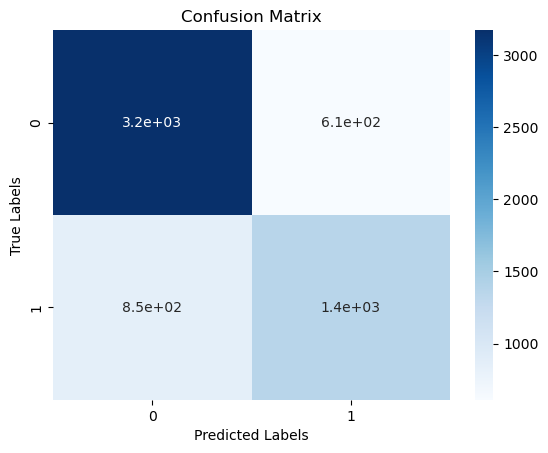

In [10]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
#Classification Report
print("Classification Report (Default Threshold):")
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
!pip install xgboost

In [13]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

# Calculate the training accuracy
train_accuracy = model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Calculate the testing accuracy
test_accuracy = model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.8219063893635644
Testing Accuracy: 0.7541256876146024


Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3784
           1       0.67      0.65      0.66      2215

    accuracy                           0.75      5999
   macro avg       0.74      0.73      0.73      5999
weighted avg       0.75      0.75      0.75      5999



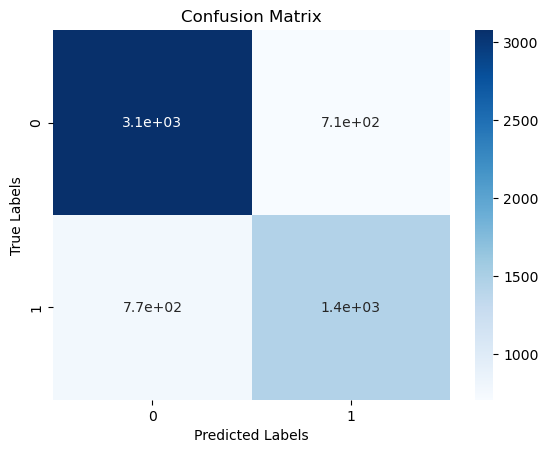

In [14]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
#Classification Report
print("Classification Report (Default Threshold):")
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# # Define the parameter grid for the grid search
# param_grid = {
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 500]
# }

# # Create an instance of the XGBClassifier
# model = XGBClassifier()

# # Create an instance of GridSearchCV with the XGBClassifier model and parameter grid
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# # Perform the grid search on the data
# grid_search.fit(X_res, y_res)

# # Get the best parameters and best score from the grid search
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and best score
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Get the best model
# best_model_XGB= grid_search.best_estimator_

# # Calculate the training accuracy of the best model
# train_accuracy = best_model_XGB.score(X_res, y_res)
# print("Training Accuracy:", train_accuracy)

# # Calculate the testing accuracy of the best model
# test_accuracy = best_model_XGB.score(X_test, y_test)
# print("Testing Accuracy:", test_accuracy)

In [ ]:
# # Make predictions on the testing data
# y_pred = best_model.predict(X_test)
# #Classification Report
# print("Classification Report (Default Threshold):")
# print(classification_report(y_test, y_pred))
# # Plot the confusion matrix
# confusion_mat = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_mat, annot=True, cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()